Script for testing different resampling methods on the dataset.

In [ ]:
import sys
from pathlib import Path

# Add the parent directory to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

import os 
import pandas as pd
import utils
from scipy.interpolate import interp1d, PchipInterpolator
import re
import datetime
import shutil
import matplotlib.pyplot as plt

In [ ]:
def copy_folder_structure(source_dir, destination_dir) -> list:
    """
    Recursively copies the folder structure from source_dir to destination_dir.
    This function will return paths of found files and destination.
    
    Parameters:
    - source_dir: The directory whose structure is to be copied.
    - destination_dir: The directory where the structure will be replicated.
    
    Returns:
    - A list of tuples containing the source and destination paths of the files.
    """
    
    csv_files = []
    for root, _, files in os.walk(source_dir):
        # Generate the corresponding destination directory path
        dest_root = os.path.join(destination_dir, os.path.relpath(root, source_dir))
    
        for file in files:
            if file.endswith('.csv'):
                
                # Check if file has milisecond timestamp
                if "_" not in file:
                    miliseconds = int(re.findall(r'\d+', file)[0])
                    timestamp = miliseconds / 1000  # Convert milliseconds to seconds
                    date_time = datetime.datetime.fromtimestamp(timestamp)
                    formatted_time = "_" + date_time.strftime("%d_%m_%Y_%H_%M_%S")
                    new_name = file.replace(str(miliseconds), formatted_time)
                    
                    # Rename the file
                    os.rename(os.path.join(root, file), os.path.join(root, new_name))
                    src_file = os.path.join(root, new_name)
                    dest_file = os.path.join(dest_root, new_name)
                
                else: 
                    src_file = os.path.join(root, file)
                    dest_file = os.path.join(dest_root, file)
               
                csv_files.append((src_file, dest_file))

            if file.endswith('.txt'):
                if not os.path.exists(dest_root):
                    os.makedirs(dest_root)
                shutil.copy(os.path.join(root, file), os.path.join(dest_root, file))
                
        # Create the directory in the destination if it doesn't exist
        if not os.path.exists(dest_root):
            os.makedirs(dest_root)

    return csv_files

In [ ]:
def pchip_interpolate(series):
    # Get the index and values, drop NaN values for interpolation
    index = series.index
    valid = series.dropna()
    interpolator = PchipInterpolator(valid.index, valid.values)
    return pd.Series(interpolator(index), index=index)

In [ ]:
def fotmat_df(df, include_label=False):
    """Remove and add necceary columns to the dataframe"""
    # Drop duplicates
    df = df.drop_duplicates(subset=['timestamp', 'sensor'], keep='first')
    
    pivoted_df = df.pivot(index='timestamp', columns='sensor', values=['value_0', 'value_1', 'value_2'])
    # Flatten the MultiIndex columns
    pivoted_df.columns = [f'{sensor}_{val.split("_")[-1]}' for val, sensor in pivoted_df.columns]
    # Reset the index to make 'timestamp' a column again
    pivoted_df.reset_index(inplace=True)
    
    # remove columns
    if "LIGHT_0" in pivoted_df.columns:
        pivoted_df = pivoted_df.drop(columns=["LIGHT_1", "LIGHT_2"])
        # rename columns LIGHT_0 to LIGHT
        pivoted_df = pivoted_df.rename(columns={"LIGHT_0": "LIGHT"})
    
    if "PRESS_0" in pivoted_df.columns:
        pivoted_df = pivoted_df.drop(columns=['PRESS_1', "PRESS_2"])
        # rename columns PRESS_0 to PRESS
        pivoted_df = pivoted_df.rename(columns={"PRESS_0": "PRESS"})
        
    if "LIGHT" not in pivoted_df.columns:
        pivoted_df['LIGHT'] = 0
    
    if "PRESS" not in pivoted_df.columns:
        pivoted_df['PRESS'] = 0
        
    # add label column 
    if include_label: pivoted_df['label'] = 0
    
    return pivoted_df

In [ ]:
def get_sampling_fs(df):
    df['time_diff'] = df['datetime'].diff().dt.total_seconds()
    avg_time_interval = df['time_diff'].mean()
    
    # Calculate the sampling rate (frequency)
    sampling_rate = 1 / avg_time_interval
    return round(sampling_rate,4)

In [ ]:
def downsample(df, factor):
    df_downsampled = df.set_index('datetime')
    df_downsampled = df_downsampled.resample(factor).mean()
    df_downsampled = df_downsampled.reset_index()
    return df_downsampled

In [ ]:
def resample_recording_1(df, x_new, kind='cubic'):
    # Initialize a new DataFrame to store the resampled values
    df_new = pd.DataFrame()

    # Iterate over each sensor type in the original DataFrame
    sensor_types = df['sensor'].unique()
    for sensor in sensor_types:
        # Filter the DataFrame by sensor type
        df_sensor = df[df['sensor'] == sensor]

        # Initialize a dictionary to store interpolated data for this sensor
        interpolated_data = {}

        # Interpolate each column except for 'sensor' and 'timestamp'
        for column in df_sensor.columns.difference(['sensor', 'timestamp']):
            # Setup the interpolation function
            f = interp1d(df_sensor['timestamp'].values, df_sensor[column].values, kind=kind, fill_value="extrapolate")

            # Perform interpolation at new time points
            interpolated_data[column] = f(x_new)

        # Create a new DataFrame for the interpolated sensor data
        df_sensor_new = pd.DataFrame(interpolated_data, index=x_new)
        df_sensor_new['sensor'] = sensor  # Add the sensor column
        df_sensor_new['timestamp'] = x_new  # Add the new timestamp

        # Append the resampled data for this sensor to the main DataFrame
        df_new = pd.concat([df_new, df_sensor_new])

    
    df_new = fotmat_df(df_new)
    return df_new
    

In [ ]:
def resampling_2(df, include_label=False):
    df_new = fotmat_df(df, include_label=include_label)
    df_new["datetime"] = pd.to_datetime(df_new["timestamp"])
    
    columns_to_transform = df_new.columns.difference(['timestamp', 'datetime'])
    df_new[columns_to_transform] = df_new[columns_to_transform].apply(pchip_interpolate)

    fs = get_sampling_fs(df_new)
    print(f"Sampling frequency: {fs} Hz")
    
    # Downsample the data to 30 Hz
    df_downsampled = downsample(df_new, '33ms')
    fs_downsampled = get_sampling_fs(df_downsampled)
    
    print(f"Downsampled frequency: {fs_downsampled} Hz")
    # remove datetime and time_diff columns
    df_downsampled = df_downsampled.drop(columns=['datetime', 'time_diff'])
    
    # remove rows with NaN values
    df_downsampled = df_downsampled.dropna()
    
    return df_downsampled

In [ ]:
def resampling_3(df, include_label=False):
    df_new = fotmat_df(df, include_label=include_label)
    return df_new

In [ ]:
# Create a list to store the paths of the processed files
source_directory = r"data_omar_raw"
destination_directory = r"data_omar_processed"
csv_files = copy_folder_structure(source_directory, destination_directory)

In [ ]:
# # Apply the second resampling method (working)
for src_file, dest_file in csv_files:
    if os.path.exists(dest_file):
        continue
    
    df, _, _ = utils.load_recording(src_file)
    df_downsampled = resampling_2(df, include_label=True)
    print(f"Saving {dest_file}")
    df_downsampled.to_csv(dest_file, index=False)

Sampling frequency: 365.9216 Hz
Downsampled frequency: 30.303 Hz
Saving C:\Users\omare\OneDrive\Documentos\TU Berlin\Master\Codigo\Master\data\data_omar_processed\pixel\12_09_24\Breaststroke_12_09_2024_13_10_50.csv
Sampling frequency: 374.4256 Hz
Downsampled frequency: 30.303 Hz
Saving C:\Users\omare\OneDrive\Documentos\TU Berlin\Master\Codigo\Master\data\data_omar_processed\pixel\12_09_24\Breaststroke_12_09_2024_13_12_29.csv
Sampling frequency: 374.9998 Hz
Downsampled frequency: 30.303 Hz
Saving C:\Users\omare\OneDrive\Documentos\TU Berlin\Master\Codigo\Master\data\data_omar_processed\pixel\12_09_24\Breaststroke_12_09_2024_13_15_06.csv
Sampling frequency: 374.7424 Hz
Downsampled frequency: 30.303 Hz
Saving C:\Users\omare\OneDrive\Documentos\TU Berlin\Master\Codigo\Master\data\data_omar_processed\pixel\12_09_24\Breaststroke_12_09_2024_13_17_09.csv
Sampling frequency: 374.9402 Hz
Downsampled frequency: 30.303 Hz
Saving C:\Users\omare\OneDrive\Documentos\TU Berlin\Master\Codigo\Master\da

In [ ]:
df, _, _ = utils.load_recording(r"Freestyle_Kick_03_07_2024_09_20_44.csv")
df_old = fotmat_df(df)

In [ ]:
df_new = fotmat_df(df)
df_new["datetime"] = pd.to_datetime(df_new["timestamp"])

columns_to_transform = df_new.columns.difference(['timestamp', 'datetime'])
df_new[columns_to_transform] = df_new[columns_to_transform].apply(pchip_interpolate)

fs = get_sampling_fs(df_new)
print(f"Sampling frequency: {fs} Hz")

# Downsample the data to 30 Hz
df_downsampled = downsample(df_new, '33ms')
fs_downsampled = get_sampling_fs(df_downsampled)

df_downsampled = df_downsampled.drop(columns=['datetime', 'time_diff'])

# remove rows with NaN values
df_downsampled = df_downsampled.dropna()

Sampling frequency: 369.5861 Hz


In [ ]:
df_new

,timestamp,ACC_0,GYRO_0,LIGHT,MAG_0,PRESS,ACC_1,GYRO_1,MAG_1,ACC_2,GYRO_2,MAG_2,datetime,time_diff
0,79322214575573,-0.061086,0.528654,920.326233,-26.421560,1005.204050,5.463165,0.033924,-53.313196,8.334436,0.116426,-9.123630,1970-01-01 22:02:02.214575573,NaN
1,79322323889573,-0.068272,0.568961,916.972013,-25.293775,1005.204031,5.438380,-0.019821,-52.987502,8.269885,0.190629,-11.587516,1970-01-01 22:02:02.323889573,0.109314
2,79322329474323,-0.075458,0.577076,913.646834,-24.459741,1005.204014,5.411386,-0.069308,-52.711808,8.193734,0.257542,-13.447236,1970-01-01 22:02:02.329474323,0.005585
3,79322335059073,-0.082644,0.560980,910.350569,-23.884042,1005.203999,5.391025,-0.067179,-52.481946,8.107497,0.261666,-14.773622,1970-01-01 22:02:02.335059073,0.005585
4,79322340643823,-0.089830,0.529984,907.083092,-23.531260,1005.203988,5.380245,-0.065982,-52.293752,8.011678,0.265657,-15.637509,1970-01-01 22:02:02.340643823,0.005585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37170,79422782480948,2.599094,0.120923,377.539254,0.149795,1005.220541,5.425759,-0.081812,-14.185067,7.896695,0.012904,-45.168751,1970-01-01 22:03:42.782480948,0.004963
37171,79422787443823,2.520043,0.110280,369.089849,0.097313,1005.221865,5.587454,-0.065716,-14.008064,7.876333,0.015830,-45.168751,1970-01-01 22:03:42.787443823,0.004963
37172,79422787726573,2.472665,0.102617,360.577549,0.017655,1005.223511,5.662773,-0.056877,-13.826007,7.841096,0.019415,-45.168751,1970-01-01 22:03:42.787726573,0.000283
37173,79422792406698,2.414642,0.094184,352.002160,-0.092745,1005.225489,5.701239,-0.050684,-13.641745,7.817644,0.024211,-45.168751,1970-01-01 22:03:42.792406698,0.004680


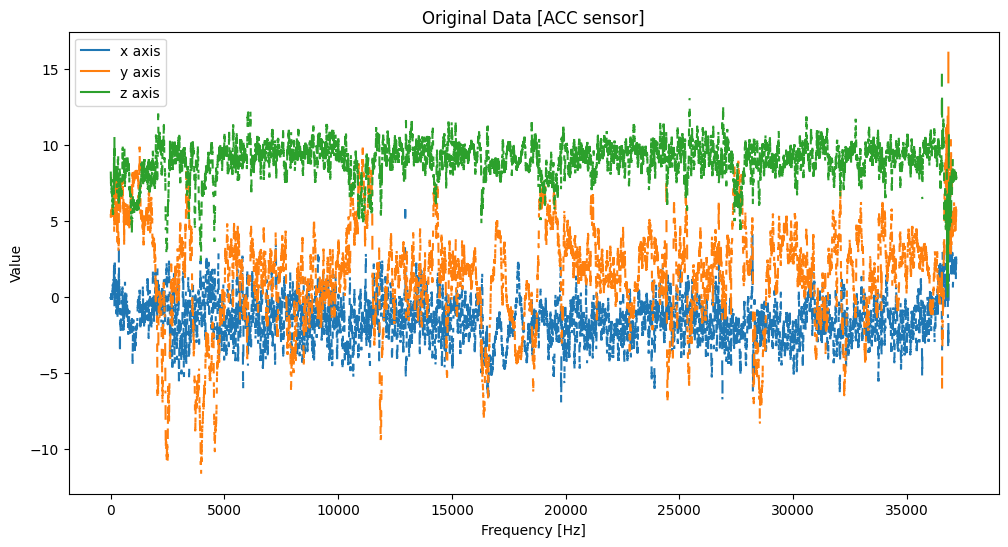

In [ ]:
# Create a separate figure for each df_new and df_downsampled
fig = plt.figure(figsize=(12, 6))

plt.plot(df_old["ACC_0"].values, label='x axis')
plt.plot(df_old["ACC_1"].values, label='y axis')
plt.plot(df_old["ACC_2"].values, label='z axis')

plt.title('Original Data [ACC sensor]')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Value')
plt.legend()
plt.show()

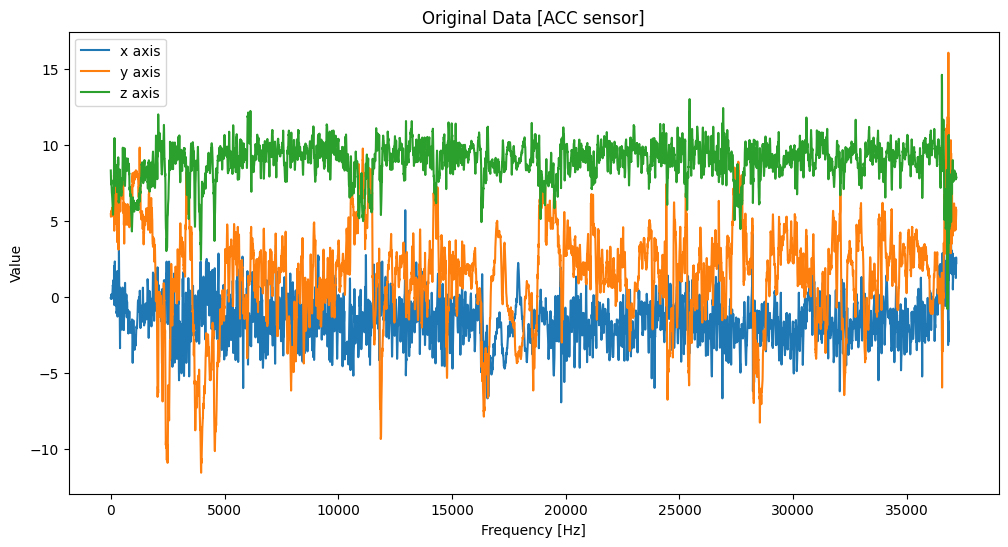

In [ ]:
# Create a separate figure for each df_new and df_downsampled
fig = plt.figure(figsize=(12, 6))

plt.plot(df_new["ACC_0"].values, label='x axis')
plt.plot(df_new["ACC_1"].values, label='y axis')
plt.plot(df_new["ACC_2"].values, label='z axis')

plt.title('Original Data [ACC sensor]')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Value')
plt.legend()
plt.show()

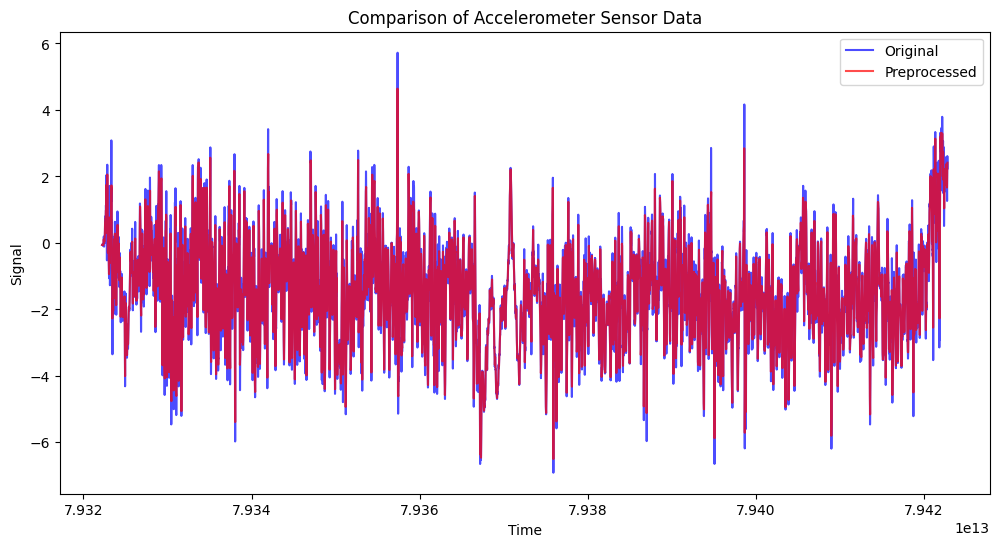

In [ ]:
fig = plt.figure(figsize=(12, 6))

plt.plot(df_new["timestamp"], df_new["ACC_0"].values, label='Original', color='blue', alpha=0.7)
plt.plot(df_downsampled["timestamp"], df_downsampled["ACC_0"].values, label='Preprocessed', color='red', alpha=0.7)


plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Comparison of Accelerometer Sensor Data')
plt.legend()
plt.show()